In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import njit
%matplotlib inline

In [12]:
# load the data in training_dictionary.txt
with open("training_dictionary.txt", "r") as file:
    all_words = file.read().splitlines()
print(len(all_words))

224377


100%|██████████| 224377/224377 [00:00<00:00, 4151288.25it/s]

count    224377.000000
mean          9.591540
std           2.916634
min           1.000000
25%           8.000000
50%           9.000000
75%          11.000000
max          24.000000
Name: word_length, dtype: float64


array([[<Axes: title={'center': 'word_length'}>]], dtype=object)

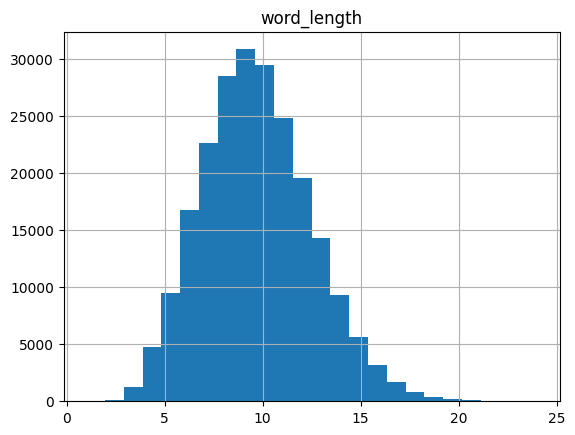

In [13]:
import pandas as pd

df = pd.DataFrame(
    {
        "word_length": [len(word) for word in tqdm(all_words)],
    }
)

print(df["word_length"].describe())

df.hist(column="word_length", bins=df["word_length"].max())

In [14]:
max_length = 25

words = [word for word in all_words if len(word) <= max_length]

In [15]:
import random

print(len(words))
random.seed(42)
random.shuffle(words)
words[:10]

224377


['reperplex',
 'dice',
 'hemibenthic',
 'plumatellid',
 'delatinize',
 'mermithization',
 'rixatrix',
 'preassurance',
 'desensitize',
 'mele']

In [16]:
len("".join(words))

2152121

In [17]:
longest_word = max(words, key=len)
print(longest_word, len(longest_word))

tetraiodophenolphthalein 24


In [18]:
vocab = set("".join(words))
vocab = [".", "_"] + sorted(list(vocab))
vocab_size = len(vocab)
print(vocab_size)
stoi = {char: i for i, char in enumerate(vocab)}
itos = {i: char for char, i in stoi.items()}
print(stoi)
print(itos)

29
{'.': 0, '_': 1, '-': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28}
{0: '.', 1: '_', 2: '-', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'k', 14: 'l', 15: 'm', 16: 'n', 17: 'o', 18: 'p', 19: 'q', 20: 'r', 21: 's', 22: 't', 23: 'u', 24: 'v', 25: 'w', 26: 'x', 27: 'y', 28: 'z'}


In [19]:
# create a dataset where each character is masked with an underscore
block_size = max_length
dataset = []
# Truncate word to block_size or fill them with '.' if it's too short. Use '_' for the single masked character. There must only be one '_' per word.
truncated_words = []
for word in words:
    # Pad shorter words with '.' to match block_size
    if len(word) < block_size:
        word = word + "." * (block_size - len(word))

    # Use sliding window to generate subwords
    for i in range(len(word) - block_size + 1):
        subword = word[i : i + block_size]
        truncated_words.append(subword)

print(len(truncated_words))
truncated_words[:30]

224377


['reperplex................',
 'dice.....................',
 'hemibenthic..............',
 'plumatellid..............',
 'delatinize...............',
 'mermithization...........',
 'rixatrix.................',
 'preassurance.............',
 'desensitize..............',
 'mele.....................',
 'codfisher................',
 'metrorrhagia.............',
 'dispiece.................',
 'malagigi.................',
 'undetractingly...........',
 'vanillal.................',
 'dowery...................',
 'blepharal................',
 'osnappar.................',
 'phoronic.................',
 'behold...................',
 'brigand..................',
 'lots.....................',
 'thingamabob..............',
 'aureation................',
 'phosphene................',
 'kolach...................',
 'raja.....................',
 'rhipiphorid..............',
 'unagitatedly.............']

In [20]:
def masked_words(word: str):
    if not word:
        return []

    result = []

    # Get unique characters in the word
    unique_chars = list(set(word) - {"."})

    # Generate all possible combinations of which characters to mask
    # For n unique characters, we have 2^n possibilities
    for i in range(1, 2 ** len(unique_chars)):  # Start from 1 to exclude no masks
        chars_to_mask = set()

        # Determine which characters to mask based on bit pattern
        for j in range(len(unique_chars)):
            if i & (1 << j):
                chars_to_mask.add(unique_chars[j])

        # Create the masked string
        masked = ""
        for char in word:
            if char in chars_to_mask:
                masked += "_"
            else:
                masked += char

        # Create a tuple for each masked character type
        # for char in chars_to_mask:
        result.append((masked, word))

    return result


print(masked_words("app"))
print(masked_words("app."))
print(masked_words("xyz"))
print(masked_words("xyz.."))

[('a__', 'app'), ('_pp', 'app'), ('___', 'app')]
[('a__.', 'app.'), ('_pp.', 'app.'), ('___.', 'app.')]
[('xy_', 'xyz'), ('x_z', 'xyz'), ('x__', 'xyz'), ('_yz', 'xyz'), ('_y_', 'xyz'), ('__z', 'xyz'), ('___', 'xyz')]
[('xy_..', 'xyz..'), ('x_z..', 'xyz..'), ('x__..', 'xyz..'), ('_yz..', 'xyz..'), ('_y_..', 'xyz..'), ('__z..', 'xyz..'), ('___..', 'xyz..')]


In [22]:
%%time
def gen_dataset(truncated_words: list[str]):
    dataset = []
    for word in truncated_words:
        dataset.extend(masked_words(word))
    return dataset


# dataset = list(set(dataset))

# print the first 10 elements of the dataset
dataset = gen_dataset(truncated_words[:10_000])
print(len(dataset))
print(dataset[:10])

4690196
[('re_er_lex................', 'reperplex................'), ('r_p_rpl_x................', 'reperplex................'), ('r___r_l_x................', 'reperplex................'), ('_epe_plex................', 'reperplex................'), ('_e_e__lex................', 'reperplex................'), ('__p__pl_x................', 'reperplex................'), ('______l_x................', 'reperplex................'), ('reperp_ex................', 'reperplex................'), ('re_er__ex................', 'reperplex................'), ('r_p_rp__x................', 'reperplex................')]
CPU times: user 13.5 s, sys: 1.26 s, total: 14.7 s
Wall time: 14.7 s


In [23]:
random.seed(42)
random.shuffle(dataset)
dataset = dataset[:2_000_000]

In [24]:
%%time
# convert the words to a list of ints
integerized_dataset = []
for word, label in dataset:
    integerized_dataset.append(
        ([stoi[char] for char in word], [stoi[char] for char in label])
    )

print(integerized_dataset[0])

([1, 1, 1, 22, 1, 22, 1, 18, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [24, 17, 14, 22, 3, 22, 27, 18, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [25]:
# create a pytorch dataset of word and label pairs
from torch.utils.data import Dataset
import random


class HangmanDataset(Dataset):
    def __init__(self, words):
        self.features = torch.tensor([x[0] for x in words])
        self.labels = torch.tensor([x[1] for x in words])

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


split_idx = int(len(integerized_dataset) * 1)
shuffled_integerized_dataset = list(integerized_dataset)
random.shuffle(shuffled_integerized_dataset)
train_split = shuffled_integerized_dataset[:split_idx]
val_split = shuffled_integerized_dataset[split_idx:]

train_dataset = HangmanDataset(train_split)
val_dataset = HangmanDataset(val_split)

print(len(train_dataset))
print(train_dataset[[0, 1, 2]])

print(len(val_dataset))

2000000
(tensor([[ 1,  1,  7, 18,  1,  3, 20,  1,  1,  1, 20,  1,  1, 11,  1, 20,  1,  1,
         11,  1,  0,  0,  0,  0,  0],
        [ 1, 20, 27,  1,  1,  1, 17,  1, 17,  1,  1,  5,  1,  1,  1, 14,  0,  0,
          0,  0,  0,  0,  0,  0,  0],
        [ 1,  1, 22,  1, 20,  5,  1,  1, 22,  1, 10, 23,  1,  1, 20,  1, 14,  0,
          0,  0,  0,  0,  0,  0,  0]]), tensor([[ 4, 14,  7, 18, 10,  3, 20, 17,  5, 10, 20, 17, 15, 11,  6, 20, 17, 21,
         11, 21,  0,  0,  0,  0,  0],
        [22, 20, 27, 18,  3, 16, 17, 21, 17, 15,  3,  5, 11,  6,  3, 14,  0,  0,
          0,  0,  0,  0,  0,  0,  0],
        [11, 16, 22,  7, 20,  5, 17, 21, 22, 17, 10, 23, 15,  7, 20,  3, 14,  0,
          0,  0,  0,  0,  0,  0,  0]]))
0


In [26]:
# Create a transformer model for the hangman game

import torch
import torch.nn as nn
import torch.optim as optim
import math
from tqdm import tqdm

d_model = 256
nhead = 8
num_layers = 3

device = (
    "cuda"
    if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() else "cpu")
)

print("Using device:", device)


class HangmanTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, dropout=0):
        super(HangmanTransformer, self).__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.num_layers = num_layers
        self.dropout = dropout

        # Create positional encoding matrix
        self.embedding = nn.Embedding(vocab_size, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, batch_first=True, dropout=dropout
        )
        self.position_embedding_table = nn.Embedding(block_size, d_model)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.ln_f = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, src):
        src = self.embedding(src)
        pos_emb = self.position_embedding_table(
            torch.arange(block_size).to(device)
        )  # (T,C)
        src = src + pos_emb
        output = self.transformer_encoder(src)
        output = self.ln_f(output)
        logits = self.fc(output)
        return logits


# create a transformer model
model = HangmanTransformer(vocab_size, d_model, nhead, num_layers)

model.to(device)
# create a loss function
criterion = nn.CrossEntropyLoss()

# create an optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# train the model
batch_size = 512
num_epochs = 1

lossi = []

for epoch in range(num_epochs):
    for i in (pbar := tqdm(range(0, len(train_dataset), batch_size))):
        # idx = torch.randint(0, len(train_dataset), (batch_size,))
        features, labels = train_dataset[i : i + batch_size]
        features = features.to(device)
        labels = labels.to(device)
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        logits = model(features)

        # Calculate loss
        loss = criterion(logits.view(-1, vocab_size), labels.view(-1))

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs} | Loss: {loss.item():.4f}")
        lossi.append(loss.item())

Using device: cuda


Epoch 1/1 | Loss: 0.1664: 100%|██████████| 3907/3907 [01:59<00:00, 32.68it/s]


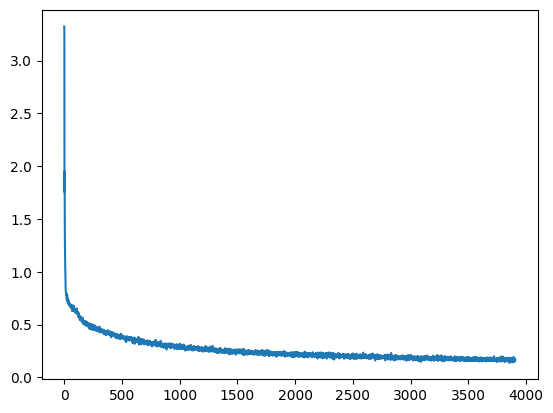

In [27]:
plt.plot(lossi)
plt.show()

In [28]:
model.eval()
val_dataset = train_dataset[:20000]
with torch.no_grad():
    losses = []
    for i in (pbar := tqdm(range(0, len(val_dataset), batch_size))):
        features, labels = val_dataset[i : i + batch_size]
        features = features.to(device)
        labels = labels.to(device)
        logits = model(features)
        loss = criterion(logits.view(-1, vocab_size), labels.view(-1))
        losses.append(loss.item())
    print(np.mean(losses))
print("\n")

100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

0.1648380309343338




In [33]:
# inference:


def predict(model, word, max_guesses=6, verbose=False):
    if verbose:
        print("word", word)
    guesses = []
    model.eval()
    with torch.no_grad():
        while True:
            # print(guesses)
            masked_word = "".join(
                ["_" if char != "." and char not in guesses else char for char in word]
            )
            if verbose:
                print("masked_word", masked_word, guesses)
            if masked_word == word:
                break
            if len([g for g in guesses if g not in word]) >= max_guesses:
                break

            features = torch.tensor([[stoi[c] for c in masked_word]]).to(device)
            # print("features", features)
            logits = model.forward(features)
            probs = torch.softmax(logits, dim=2)
            # print("probs", probs)
            # print("max", torch.max(probs, dim=2).values)
            most_confident_index = torch.topk(
                torch.max(probs, dim=2).values, k=len(masked_word), dim=1
            ).indices[0]
            if verbose:
                print("most_confident_index", most_confident_index)
            indices = torch.topk(probs, k=vocab_size, dim=2).indices
            # print("indices", indices)
            for i in most_confident_index:
                if masked_word[i] == "_":
                    letter_guesses = [itos[j.item()] for j in indices[0, i]]
                    break
            if verbose:
                print("letter_guesses", letter_guesses)
            for letter_guess in letter_guesses:
                if letter_guess not in guesses and letter_guess not in [".", "_"]:
                    guesses.append(letter_guess)
                    if (
                        letter_guess in word
                        or len([g for g in guesses if g not in word]) == max_guesses
                    ):
                        break
                    # break
    return masked_word, guesses


predict(model, truncated_words[0], max_guesses=6, verbose=True)
print(len(truncated_words))

wins = 0
total = 0
for word in (pbar := tqdm(truncated_words[:5000])):
    masked_word, guesses = predict(model, word, max_guesses=6, verbose=False)
    if masked_word == word:
        wins += 1
    total += 1
    pbar.set_description(f"Win rate: {wins / total * 100:.2f}%")

# Win Rates
# 2 chars: 31.58% (133)
# 3 chars: 24.10% (1249)
# 4 chars: 23.34% (4798)
# 5 chars: 37.19% (9522)
# 6 chars: 34.19% (16763)
# 7 chars: 43.69% (22675)
# 8 chars: 60.68% (28512)
# 9 chars: 74.61% (30882)

word reperplex................
masked_word _________................ []
most_confident_index tensor([ 9, 19, 24, 12, 21, 20, 15, 14, 13, 22, 17, 23, 11, 10, 16, 18,  6,  8,
         0,  1,  4,  7,  3,  5,  2], device='cuda:0')
letter_guesses ['i', 'e', 'a', 't', 'o', 'r', 'n', 'l', 'd', 'u', 'b', 'c', 'g', 's', 'm', 'y', 'h', 'p', 'k', 'w', 'f', 'x', 'v', 'z', 'q', 'j', '_', '-', '.']
masked_word _e_e___e_................ ['i', 'e']
most_confident_index tensor([ 1,  3,  7, 19,  9, 24, 12, 14, 13, 15, 20, 21, 22, 11, 10, 17, 23, 16,
        18,  8,  4,  5,  2,  6,  0], device='cuda:0')
letter_guesses ['r', 'd', 's', 'l', 'a', 't', 'n', 'w', 'c', 'p', 'y', 'm', 'f', 'x', 'g', 'b', 'k', 'v', 'i', 'h', 'o', 'e', 'u', 'j', 'z', 'q', '_', '-', '.']
masked_word re_er__e_................ ['i', 'e', 'r']
most_confident_index tensor([ 1,  0,  7, 24,  9, 13, 14, 12,  4, 19, 20, 22, 11, 15, 21, 17, 10, 16,
        23, 18,  3,  8,  5,  6,  2], device='cuda:0')
letter_guesses ['d', 'l', 's', 't', 'n

Win rate: 75.00%:   0%|          | 8/5000 [00:00<01:08, 73.18it/s]

Win rate: 61.62%: 100%|██████████| 5000/5000 [01:08<00:00, 72.49it/s]


,max_length,win_rate,num_words
0,6,40.58,32490
1,7,37.35,55165
2,9,46.20,114559
3,11,48.70,168974


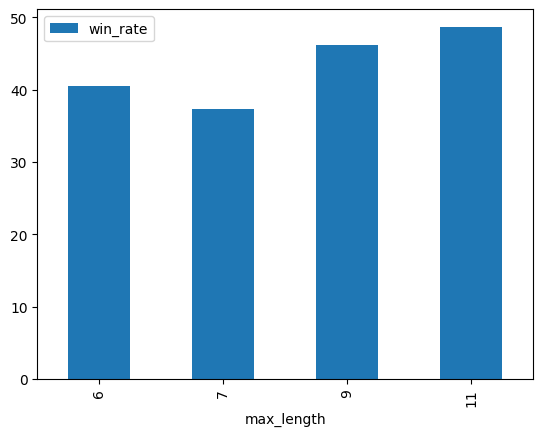

In [30]:
windf = pd.DataFrame(
    {
        "max_length": [6, 7, 9, 11, 24],
        "win_rate": [
            40.58,
            37.35,
            46.20,
            48.70,
            61.20,
        ],
        "num_words": [
            32490,
            55165,
            114559,
            168974,
        ],
    }
)
windf.plot.bar(x="max_length", y="win_rate")
windf

67.32690899834002


,word_length,win_rate,num_words
0,2,31.58,133
1,3,24.10,1249
2,4,23.34,4798
3,5,37.19,9522
4,6,34.19,16763
5,7,43.69,22675
6,8,60.68,28512
7,9,74.61,30882
8,10,83.43,29520
9,11,89.70,24895


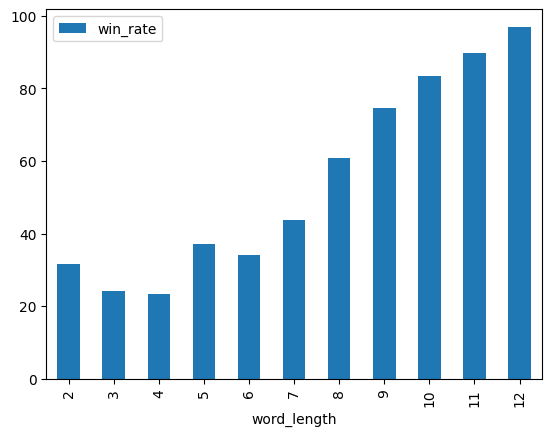

In [31]:
windf = pd.DataFrame(
    {
        "word_length": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        "win_rate": [
            31.58,
            24.10,
            23.34,
            37.19,
            34.19,
            43.69,
            60.68,
            74.61,
            83.43,
            89.70,
            96.93,
        ],
        "num_words": [
            133,
            1249,
            4798,
            9522,
            16763,
            22675,
            28512,
            30882,
            29520,
            24895,
            19608,
        ],
    }
)
print(windf["win_rate"].mul(windf["num_words"]).sum() / windf["num_words"].sum())
windf.plot.bar(x="word_length", y="win_rate")
windf